# Функции, вносящие топологический шум

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

## Функция, рисующая прямоугольники

In [2]:
def vec_product(v1, v2):
    return v1[0]*v2[1] - v1[1]*v2[0]


def in_rectangle(a, b, c, d, dot):
    v1, v2, v3, v4 = a-dot, b-dot, c-dot, d-dot
    return vec_product(v1, v2) <= 0 and vec_product(v2, v3) <= 0 and \
            vec_product(v3, v4) <= 0 and vec_product(v4, v1) <= 0


def draw_rectangle(X, coordinate_x, coordinate_y, length, width, angle, colour, need_noise, noise):
    side = X.shape[0]
    rotation_matrix = np.asmatrix(np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]))
    
    # initialize
    a = np.array([0., 0.])
    b = np.array([length*1., 0.])
    c = np.array([length*1., width*1.])
    d = np.array([0., width*1.])
    
    # rotate
    a = np.resize((rotation_matrix @ a), (2,))
    b = np.resize((rotation_matrix @ b), (2,))
    c = np.resize((rotation_matrix @ c), (2,))
    d = np.resize((rotation_matrix @ d), (2,))
    
    # move to the first quadrant
    min_coord = np.amin([a, b, c, d], axis=0)
    a -= min_coord
    b -= min_coord
    c -= min_coord
    d -= min_coord

    # cast to integer
    a = a.astype(np.int64)
    b = b.astype(np.int64)
    c = c.astype(np.int64)
    d = d.astype(np.int64)
    
    # shift
    a[0] += coordinate_x
    a[1] = coordinate_y - a[1]
    b[0] += coordinate_x
    b[1] = coordinate_y - b[1]
    c[0] += coordinate_x
    c[1] = coordinate_y - c[1]
    d[0] += coordinate_x
    d[1] = coordinate_y - d[1]
    
    # clip
    a = np.clip(a, 0, side-1)
    b = np.clip(b, 0, side-1)
    c = np.clip(c, 0, side-1)
    d = np.clip(d, 0, side-1)
    
    # max/min
    max_coord = np.amax([a, b, c, d], axis=0)
    min_coord = np.amin([a, b, c, d], axis=0)
    area = (max_coord[0]-min_coord[0]+1)*(max_coord[1]-min_coord[1]+1)
    
    # draw
    for x in range(min_coord[0], max_coord[0]+1):
        for y in range(min_coord[1], max_coord[1]+1):
            if in_rectangle(a, b, c, d, np.array([x, y])):
                X[y, x] = colour
                if need_noise:
                    noise[y, x] = colour
    
    return X, area, noise

## Шум, не зависящий от картинки

In [3]:
def independent_noise(X, percentage, length_boundary, width_coef, colour, need_noise):
    noise = []
    if need_noise:
        noise = np.zeros(X.shape)
    side = X.shape[0]
    noise_area = 0
    while noise_area/(side**2) < percentage:
        length = np.random.randint(3, length_boundary)
        width = int(width_coef*length)
        angle = np.random.rand(1)*np.pi
        bound = np.maximum(length, width)
        coordinates = np.random.randint(0, side-bound, 2)
        X, area, noise = draw_rectangle(X, coordinates[0], coordinates[1]+bound, 
                                 length, width, angle, colour, need_noise, noise)
        noise_area += area
    return X, noise

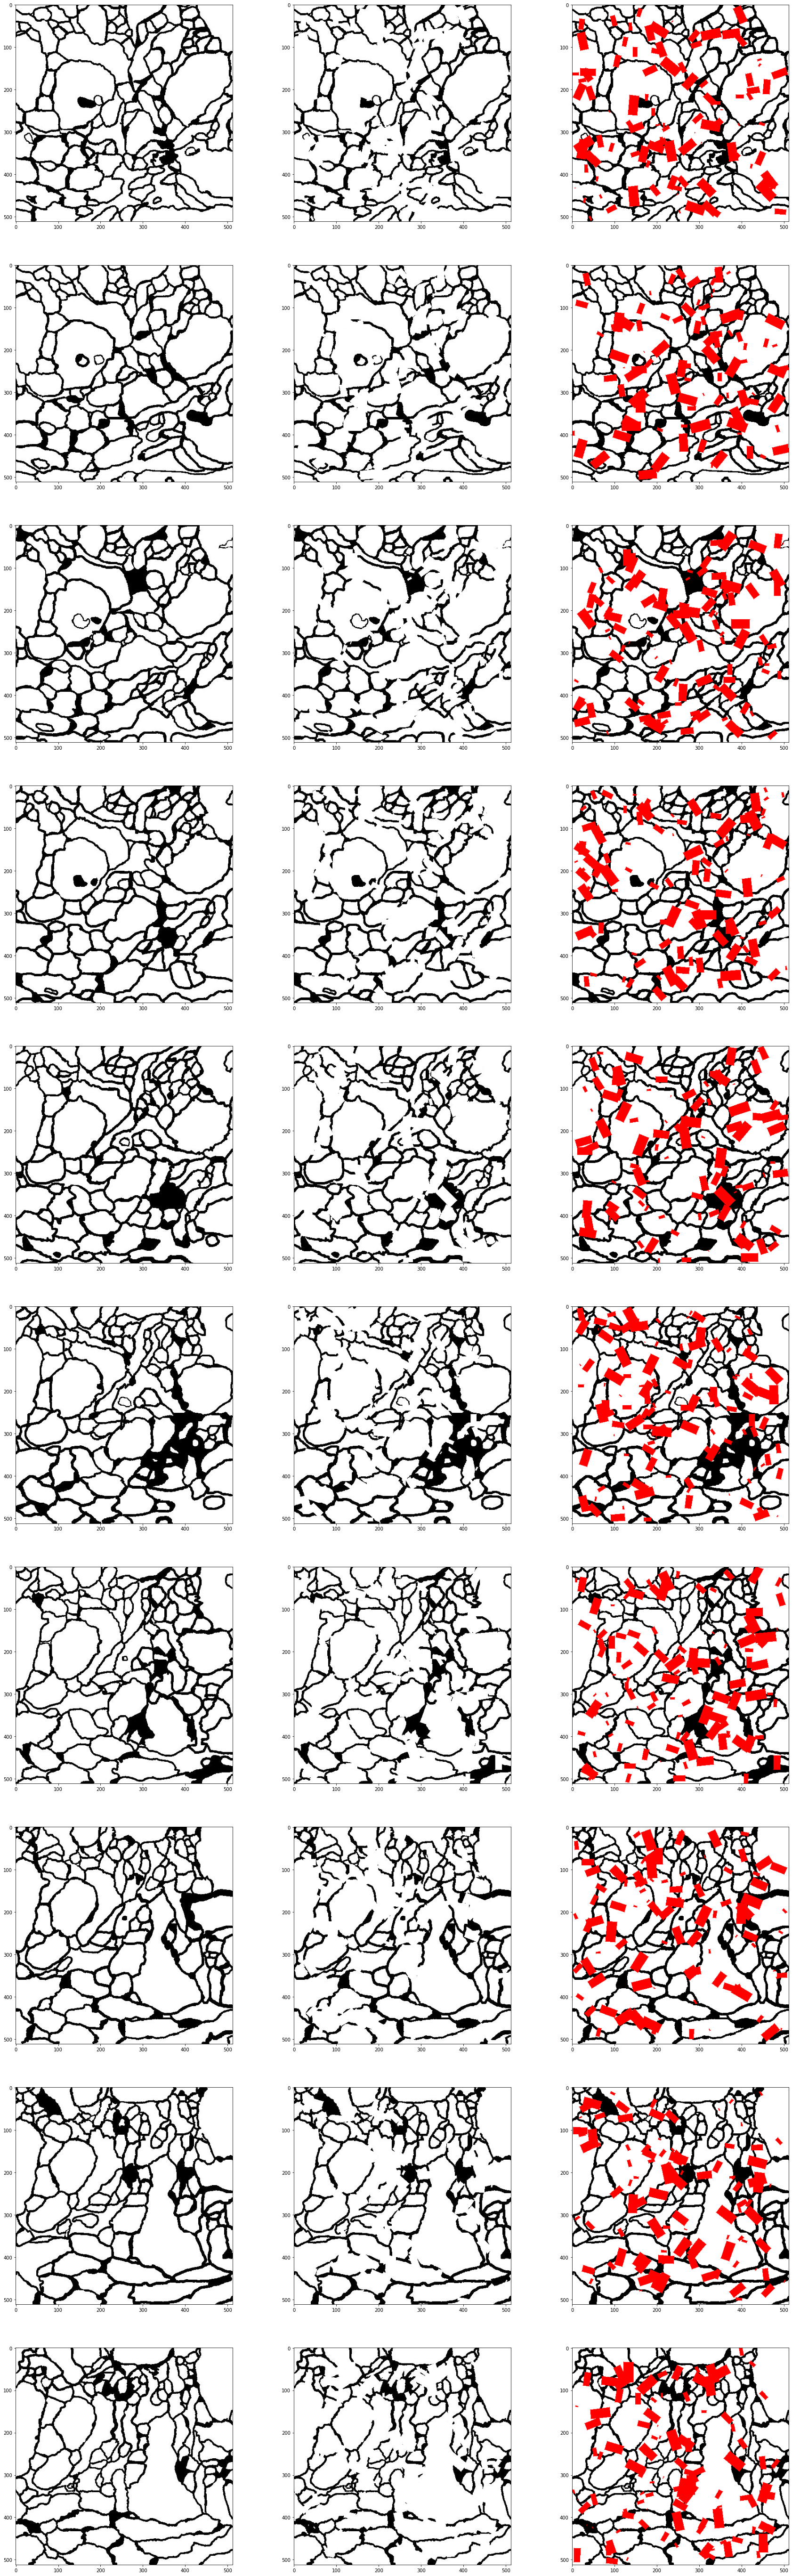

In [4]:
images_path = '../data/isbi12/'
image_names = [image_name for image_name in os.listdir(path=images_path) if image_name.endswith('.jpg')]

fig, axes = plt.subplots(10, 3, figsize=(30, 100))

for i in range(10):    
    image = cv2.imread(images_path+image_names[i], cv2.IMREAD_GRAYSCALE)
    
    axes[i, 0].imshow(image, cmap="gray")

    noise, noise_mask = independent_noise(image.copy(), percentage=0.3, length_boundary=50, 
                                          width_coef=0.5, colour=255, need_noise=True)
    axes[i, 1].imshow(noise, cmap="gray")

    coloured_noise = np.zeros((image.shape[0], image.shape[1], 3)) # red noise
    layer = (image.copy() > 128)*1
    noise_mask = (noise_mask > 0)*1
    coloured_noise[:,:,0] = np.clip(layer + noise_mask, 0, 1) # red
    coloured_noise[:,:,1] = np.clip(layer - noise_mask, 0, 1) # green
    coloured_noise[:,:,2] = np.clip(layer - noise_mask, 0, 1) # blue
    axes[i, 2].imshow(coloured_noise)

## Шум, зависящий от картинки

In [5]:
def dependent_noise(X, percentage, window, colour, need_noise):
    noise = []
    if need_noise:
        noise = np.zeros(X.shape)
    side = X.shape[0]
    angles = [np.pi/6, 5*np.pi/6, np.pi/4, 3*np.pi/4, np.pi/3, 2*np.pi/3, np.pi/2, np.pi]
    noise_area = 0
    rounds = 0
    max_rounds = 1000 # maximum number of loops
    while noise_area/(side**2) < percentage and rounds < max_rounds:
        rounds += 1
        # indicates that line suits
        suit = False
        # generate coordinates
        coordinates = np.random.randint(0, side-window, 2)
        # generate angles
        np.random.shuffle(angles)
        # trying to cross the borders with lines with different angles
        for angle in angles:
            # make line
            tan = np.tan(angle)
            cotan = np.tan(np.pi/2 - angle)
            if np.abs(tan) <= 1:
                x = np.arange(-window//2, window//2)
                y = x * tan
                mask = (y > -window/2.) & (y < window/2.)
            else:
                y = np.arange(-window//2, window//2)
                x = y * cotan
                mask = (x > -window/2.) & (x < window/2.)
            # shift with window
            x = np.clip(x + window//2, 0, window - 1)
            y = np.clip(window//2 - y, 0, window - 1)
            # shift with coordinates
            x = np.clip(x + coordinates[0], 0, side - 1)
            y = np.clip(y + coordinates[1], 0, side - 1)
            I = y[mask].astype(np.int64)
            J = x[mask].astype(np.int64)
            # check for crossing
            previous = 0
            cross = 0
            for itr, (i, j) in enumerate(zip(I, J)):
                if itr != 0:
                    if cross == 0 and previous >= colour*0.25 and colour*0.75 >= X[i,j]:
                        cross += 1
                    elif cross > 0 and previous <= colour*0.25 and colour*0.75 <= X[i,j]:
                        suit = True
                        break
                previous = X[i,j]
            # if line suits, draw it
            if suit:
                sin = np.sin(angle)
                cos = abs(np.cos(angle))
                if np.abs(tan) <= 1:
                    length = int(window/abs(np.cos(angle)))
                else:
                    length = int(window/np.sin(angle))
                width = length//2
                coordinates[0] += window//2
                coordinates[0] -= int(cos*length/2+(cos**2)*sin*width)
                coordinates[1] += window//2
                coordinates[1] += int(sin*length/2+(sin**2)*cos*width)
                X, area, noise = draw_rectangle(X, coordinates[0], coordinates[1], 
                                                length, width, angle, colour, 
                                                need_noise, noise)
                noise_area += area
                break
    return X, noise

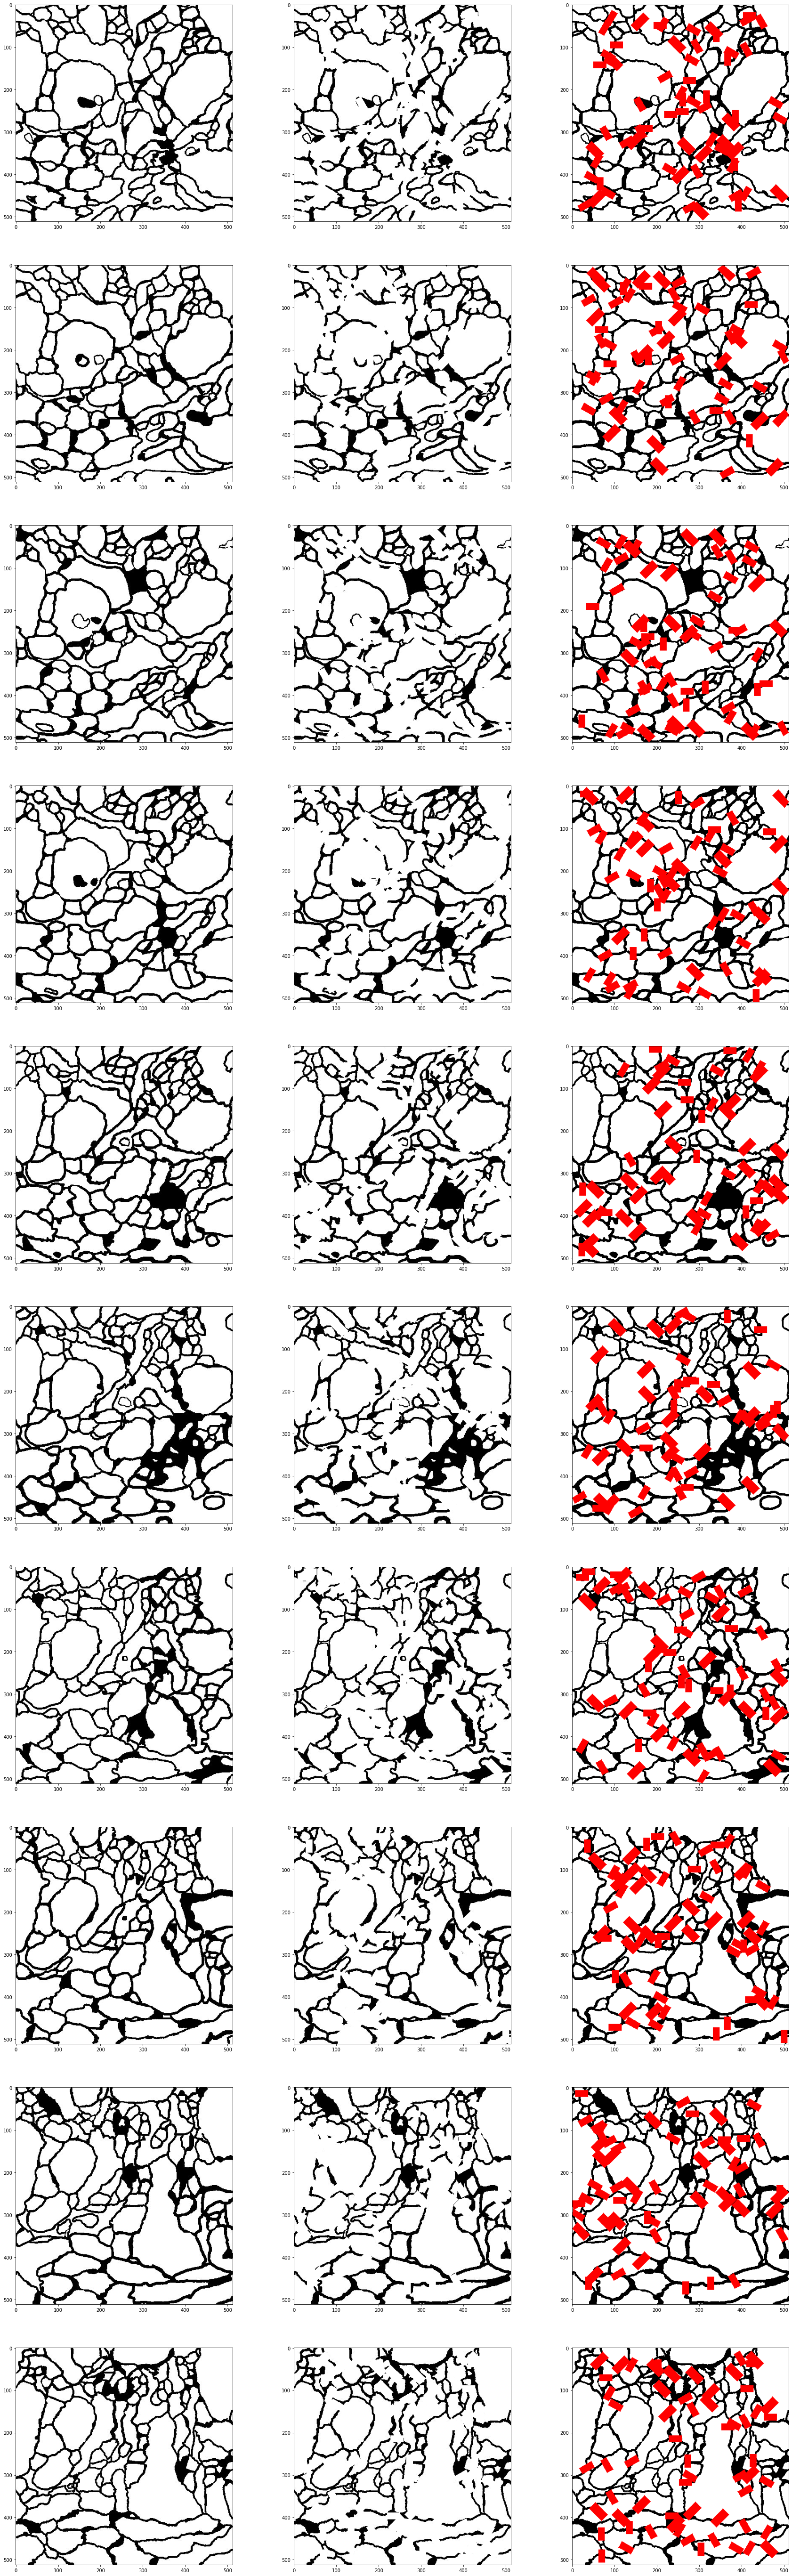

In [6]:
fig, axes = plt.subplots(10, 3, figsize=(30, 100))

for i in range(10):    
    image = cv2.imread(images_path+image_names[i], cv2.IMREAD_GRAYSCALE)
    
    axes[i, 0].imshow(image, cmap="gray")

    noise, noise_mask = dependent_noise(image.copy(), percentage=0.3, window=30,
                                        colour=255, need_noise=True)
    axes[i, 1].imshow(noise, cmap="gray")

    coloured_noise = np.zeros((image.shape[0], image.shape[1], 3)) # red noise
    layer = (image.copy() > 128)*1
    noise_mask = (noise_mask > 0)*1
    coloured_noise[:,:,0] = np.clip(layer + noise_mask, 0, 1) # red
    coloured_noise[:,:,1] = np.clip(layer - noise_mask, 0, 1) # green
    coloured_noise[:,:,2] = np.clip(layer - noise_mask, 0, 1) # blue
    axes[i, 2].imshow(coloured_noise)